# Explore work

In [1]:
import pandas as pd
import numpy as np

from scipy import stats 

# importing functions and code from wrangle module
import wrangle as w

import matplotlib.pyplot as plt
import seaborn as sns

# Turn off pink warning boxes in notebook
import warnings
warnings.filterwarnings("ignore")

# Handle large numbers w/o using scientific notation
pd.options.display.float_format = '{:.3f}'.format

# Prevent df columns from being truncated
pd.set_option('display.max_columns', None) 

import sklearn.preprocessing
# feature selection
from sklearn.feature_selection import SelectKBest, f_regression, RFE 
# modeling
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
# evaluation
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score

## Change of plan...
After some initial exploration and a discussion with an instructor I realized that the data I was looking at had target leakeage. My target variable `mvi` was derived from the `th(x)` scores that I was exploring and planning to model with so it would not be useful to create a model predicting `th(x)` using those variables. 
<br><br>
My new plan of action is to look at the `th3` Mental Health and Substance Abuse Vulnerability Index score as the target and find its drivers through exploration and modeling. I will use the same data, dropping `mvi` and creating a new features `region` with each county's geographic region and `pop_black_women` with the number of black women in the county and `perc_black_women` with the percentage of black women to the total population of each county. I will also join my combined dataframes with another dataset that has lat/long geocoordinates so that I can see my data geographically. 
#### First I will import my data, then I will create those three new features, and my final step in preparing the data for exploration will be to join the geocoordinate data to the existing dataset. 

In [2]:
train, validate, test = w.prepare_data(w.clean_data(w.acquire_data('mvi_county.csv', 'acs2017_county_data.csv')))

✅ mvi_county.csv successfully acquired.
✅ acs2017_county_data.csv successfully acquired.

✅ DataFrames successfully joined.

✅ Data is cleaned.

✅ Data has been successfully split and is ready for exploration.
train -> (1758, 28)
validate -> (754, 28)
test -> (628, 28)



In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1758 entries, 41013 to 2110
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   state          1758 non-null   object 
 1   th1            1758 non-null   float64
 2   th2            1758 non-null   float64
 3   th3            1758 non-null   float64
 4   th4            1758 non-null   float64
 5   th5            1758 non-null   float64
 6   county         1758 non-null   object 
 7   pop_total      1758 non-null   int64  
 8   pop_men        1758 non-null   int64  
 9   pop_women      1758 non-null   int64  
 10  hispanic       1758 non-null   float64
 11  white          1758 non-null   float64
 12  black          1758 non-null   float64
 13  native         1758 non-null   float64
 14  asian          1758 non-null   float64
 15  pacific        1758 non-null   float64
 16  pop_vot_age    1758 non-null   int64  
 17  income         1758 non-null   int64  
 18  pove

In [5]:
# dropping columns
cols_to_drop = ['pop_men', 'pop_vot_age', 'avg_commute', 'selfemployed', 'mvi', 'more_women']

for df in train, validate, test:
    df.drop(columns = cols_to_drop, inplace = True)

In [15]:
# creating new features
perc_black = (train.black/100)

states_to_regions = {
    'Washington': 'West', 'Oregon': 'West', 'California': 'West', 'Nevada': 'West',
    'Idaho': 'West', 'Montana': 'West', 'Wyoming': 'West', 'Utah': 'West',
    'Colorado': 'West', 'Alaska': 'West', 'Hawaii': 'West', 'Maine': 'Northeast',
    'Vermont': 'Northeast', 'New York': 'Northeast', 'New Hampshire': 'Northeast',
    'Massachusetts': 'Northeast', 'Rhode Island': 'Northeast', 'Connecticut': 'Northeast',
    'New Jersey': 'Northeast', 'Pennsylvania': 'Northeast', 'North Dakota': 'Midwest',
    'South Dakota': 'Midwest', 'Nebraska': 'Midwest', 'Kansas': 'Midwest',
    'Minnesota': 'Midwest', 'Iowa': 'Midwest', 'Missouri': 'Midwest', 'Wisconsin': 'Midwest',
    'Illinois': 'Midwest', 'Michigan': 'Midwest', 'Indiana': 'Midwest', 'Ohio': 'Midwest',
    'West Virginia': 'South', 'District of Columbia': 'South', 'Maryland': 'South',
    'Virginia': 'South', 'Kentucky': 'South', 'Tennessee': 'South', 'North Carolina': 'South',
    'Mississippi': 'South', 'Arkansas': 'South', 'Louisiana': 'South', 'Alabama': 'South',
    'Georgia': 'South', 'South Carolina': 'South', 'Florida': 'South', 'Delaware': 'South',
    'Arizona': 'Southwest', 'New Mexico': 'Southwest', 'Oklahoma': 'Southwest',
    'Texas': 'Southwest'}


for df in train, validate, test:
    df['num_black_women'] = perc_black * (train.perc_women)/100 * train.pop_total
    df['region'] = df.state.map(states_to_regions)

In [33]:
train.head(2)

,state,th1,th2,th3,th4,th5,county,pop_total,pop_women,hispanic,white,black,native,asian,pacific,income,poverty,child_poverty,wfh,employed,unemployment,perc_women,num_black_women,region
41013,Oregon,11.370,33.650,64.150,29.700,35.820,Crook County,21717,11090,7.600,88.400,0.200,0.900,0.300,0.400,41777,15.300,23.100,6.500,8828,8.300,51.100,22.195,West
45005,South Carolina,59.850,98.310,78.920,50.080,96.820,Allendale County,9402,4450,3.100,22.500,73.500,0.500,0.000,0.000,23331,30.400,52.700,1.600,2668,17.300,47.300,3268.652,South


# Q. What is the dtype and distribution of each variable?

In [119]:
train.columns

Index(['state', 'th1', 'th2', 'th3', 'th4', 'th5', 'county', 'pop_total',
       'pop_women', 'hispanic', 'white', 'black', 'native', 'asian', 'pacific',
       'income', 'poverty', 'child_poverty', 'wfh', 'employed', 'unemployment',
       'perc_women', 'num_black_women', 'region'],
      dtype='object')

In [116]:
# creating empty lists to be appended in for loop
obj_list = []
num_list = []
bool_list = []

# for loop to append df columns to corresponding lists
for col in train.columns:
    if train[col].dtype == 'O':
        obj_list.append(col)
    elif train[col].dtype == 'bool':
        bool_list.append(col)
    else:
        num_list.append(col)
        
print(f'Object List:\n{obj_list}\n\nNumeric List:\n{num_list}\n\nBool List:\n{bool_list}')

Object List:
['state', 'county', 'region']

Numeric List:
['th1', 'th2', 'th3', 'th4', 'th5', 'pop_total', 'pop_women', 'hispanic', 'white', 'black', 'native', 'asian', 'pacific', 'income', 'poverty', 'child_poverty', 'wfh', 'employed', 'unemployment', 'perc_women', 'num_black_women']

Bool List:
[]


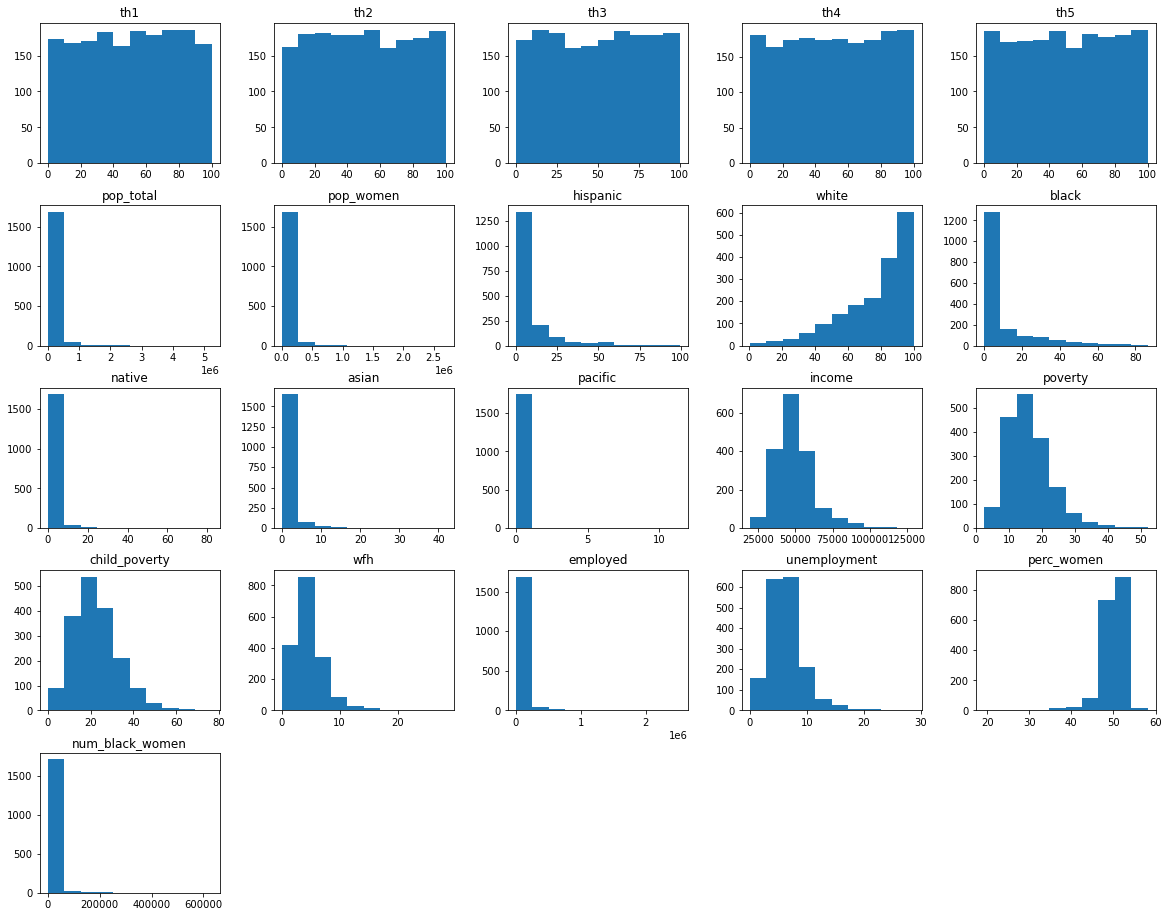

In [124]:
train.hist(grid = False, figsize = (20, 16))
plt.show()

#### There are three object columns and they are all geographic in nature:
- Region 
- State 
- County

#### I could use these variables to plot or break out my data geographically. Some questions to further explore:
- How `th3` scores vary across `region` or `state`?

Region may be a column of interest for creating dummy variables on. 

The rest of the columns are numeric and continuous in nature. At this time there are no boolean values. 

#### Distributions:
- The target `th3` is mostly uniformly distributed. 
- Most of the other columns have lots of outliers. I will leave them in for now because I am interested in looking at the more extreme values as well and seeing what is going on there. If needed, I will come by on another pass and remove them. I will use the RobustScaler to preserve them when I go into modeling. 

# Q. What does the distribution of `th3` scores look like?

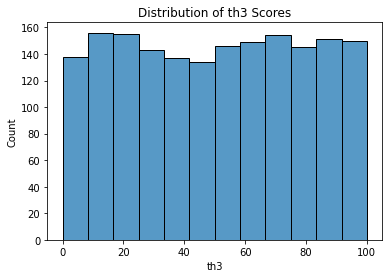

In [38]:
sns.histplot(x = train.th3)
plt.title('Distribution of th3 Scores')
plt.show();

### The `th3` scores are mostly uniformly distributed, but the distribution is slightly bimodal. 

# Q2. Which region has the highest `th3` score?


In [127]:
train.groupby('region').median().th3.sort_values(ascending = False)

region
South       74.805
Southwest   43.330
Northeast   41.450
Midwest     29.640
West        27.350
Name: th3, dtype: float64

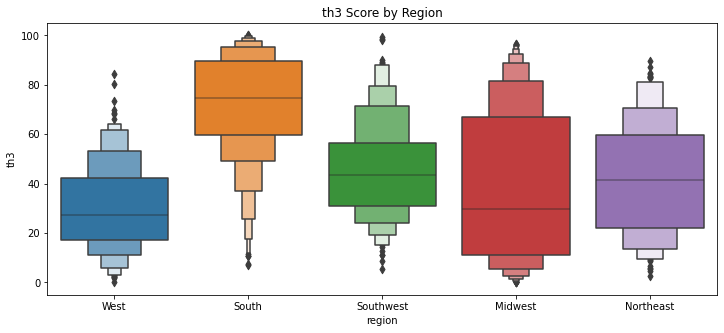

In [156]:
plt.figure(figsize = (12, 5))

sns.boxenplot(data = train, x = 'region', y = 'th3')
plt.title('th3 Score by Region')
plt.show();

#### The South region has the highest median `th3` score with most of its IQR median county scores falled above the 75th percentile of other regions counties median score. 

#### The West region has the lowest median `th3` score, with the Midwest not far behind. There is a very large gap between the southern region and the other regions. 

## Q. What does each numeric variable look like plotted against the target? 

In [140]:
def plot_numvar_target(df, x_var):
    
    '''
THIS FUNCTION TAKES IN A DF AND A NUMERIC VARIABLE TO BE PLOTTED ON THE X AXIS OF A SCATTERPLOT AGAINST
TARGET VARIABLE. IT PLOTS A SCATTER PLOT AND RUNS A SPEARMANS CORRELATION TEST, PRINTING THE R VALUE - CORRELATION
COEFFICIENT AND THE P-VALUE WHICH REPRESENTS THE PROBABILITY THAT WE ARE SEEING THE RESULTS BY CHANCE.
    '''
    
    sns.scatterplot(x = x_var, y = 'th3', data = df)
    plt.title(f'{x_var} and th3')
    plt.show();
    
    # calculate the (r) corr coefficient and (p) p-value and then print results 
    r, p = stats.spearmanr(df[x_var], df['th3'])
    print(f'The r-value or correlation coefficient is: {round(r, 2)}')
    print(f'The p-value is: {p}\nThere is {round(p, 1)}% chance that we see these results by chance.')
    print('---------------------------------------------------------------')
    print()

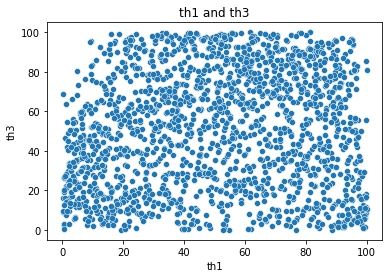

The r-value or correlation coefficient is: 0.11
The p-value is: 2.8921762177752283e-06
There is 0.0% chance that we see these results by chance.
---------------------------------------------------------------



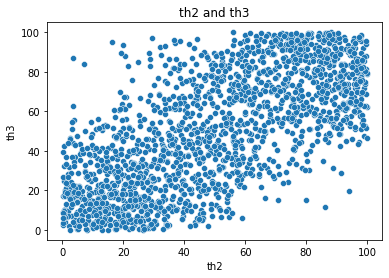

The r-value or correlation coefficient is: 0.69
The p-value is: 8.384081736316722e-246
There is 0.0% chance that we see these results by chance.
---------------------------------------------------------------



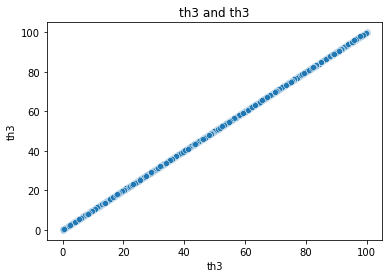

The r-value or correlation coefficient is: 1.0
The p-value is: 0.0
There is 0.0% chance that we see these results by chance.
---------------------------------------------------------------



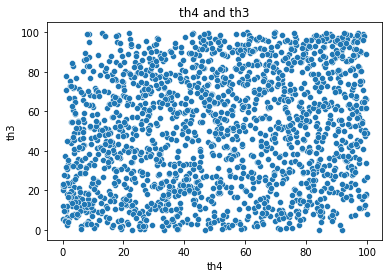

The r-value or correlation coefficient is: 0.2
The p-value is: 1.2876014766975862e-16
There is 0.0% chance that we see these results by chance.
---------------------------------------------------------------



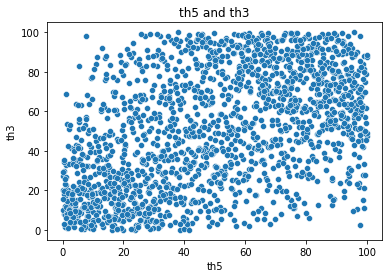

The r-value or correlation coefficient is: 0.49
The p-value is: 1.9149528889077464e-104
There is 0.0% chance that we see these results by chance.
---------------------------------------------------------------



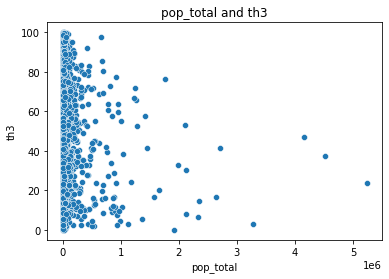

The r-value or correlation coefficient is: 0.05
The p-value is: 0.022594465332492417
There is 0.0% chance that we see these results by chance.
---------------------------------------------------------------



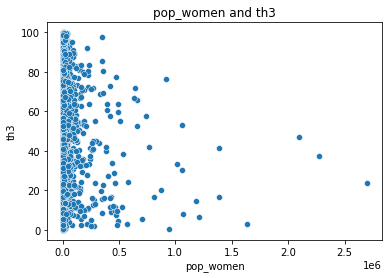

The r-value or correlation coefficient is: 0.06
The p-value is: 0.014991586390796114
There is 0.0% chance that we see these results by chance.
---------------------------------------------------------------



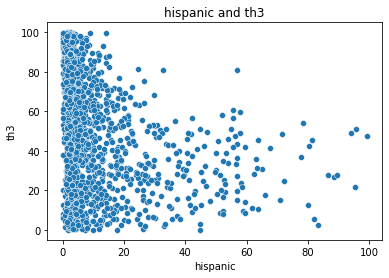

The r-value or correlation coefficient is: -0.33
The p-value is: 8.234194842818001e-45
There is 0.0% chance that we see these results by chance.
---------------------------------------------------------------



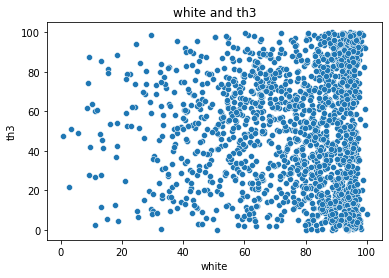

The r-value or correlation coefficient is: 0.02
The p-value is: 0.48052495876909107
There is 0.5% chance that we see these results by chance.
---------------------------------------------------------------



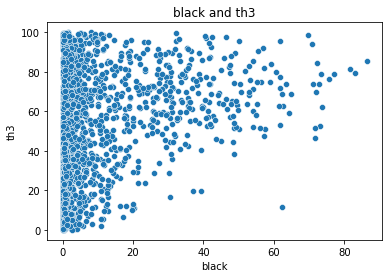

The r-value or correlation coefficient is: 0.33
The p-value is: 4.871963109178099e-45
There is 0.0% chance that we see these results by chance.
---------------------------------------------------------------



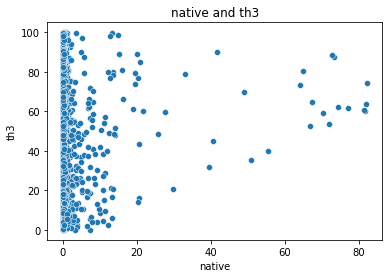

The r-value or correlation coefficient is: -0.16
The p-value is: 1.503414834378291e-11
There is 0.0% chance that we see these results by chance.
---------------------------------------------------------------



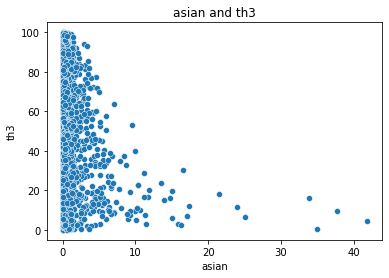

The r-value or correlation coefficient is: -0.24
The p-value is: 1.3457732001419323e-24
There is 0.0% chance that we see these results by chance.
---------------------------------------------------------------



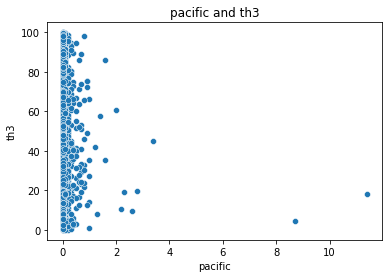

The r-value or correlation coefficient is: -0.06
The p-value is: 0.008025141077918152
There is 0.0% chance that we see these results by chance.
---------------------------------------------------------------



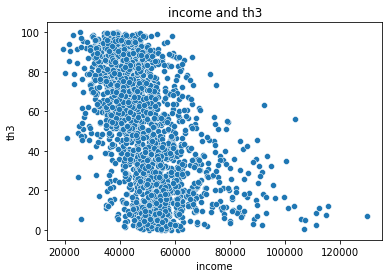

The r-value or correlation coefficient is: -0.54
The p-value is: 8.235047011828585e-136
There is 0.0% chance that we see these results by chance.
---------------------------------------------------------------



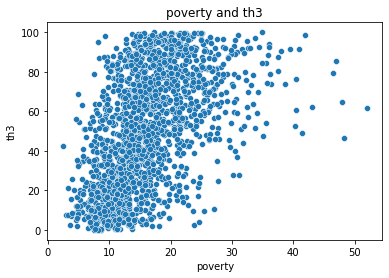

The r-value or correlation coefficient is: 0.56
The p-value is: 1.0531130213283493e-148
There is 0.0% chance that we see these results by chance.
---------------------------------------------------------------



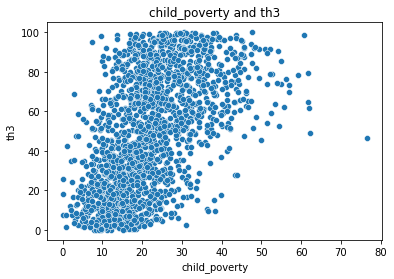

The r-value or correlation coefficient is: 0.56
The p-value is: 2.737578379232422e-144
There is 0.0% chance that we see these results by chance.
---------------------------------------------------------------



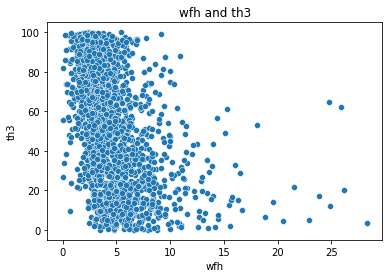

The r-value or correlation coefficient is: -0.48
The p-value is: 2.861088431216907e-101
There is 0.0% chance that we see these results by chance.
---------------------------------------------------------------



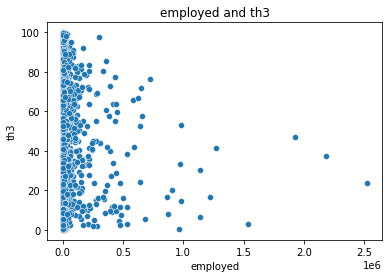

The r-value or correlation coefficient is: -0.01
The p-value is: 0.832954509658054
There is 0.8% chance that we see these results by chance.
---------------------------------------------------------------



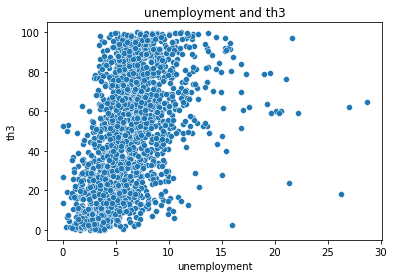

The r-value or correlation coefficient is: 0.5
The p-value is: 3.1619622240326902e-111
There is 0.0% chance that we see these results by chance.
---------------------------------------------------------------



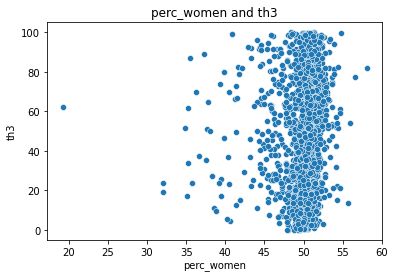

The r-value or correlation coefficient is: 0.21
The p-value is: 1.6936781972144567e-19
There is 0.0% chance that we see these results by chance.
---------------------------------------------------------------



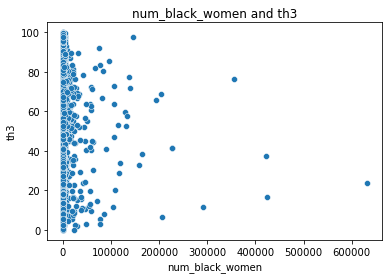

The r-value or correlation coefficient is: 0.23
The p-value is: 5.145409907588085e-23
There is 0.0% chance that we see these results by chance.
---------------------------------------------------------------



In [141]:
# for loop that will plot each num_list variable in the plot_num_var function
for var in train[num_list]:
    plot_numvar_target(train, var)

In [143]:
train.unemployment

41013    8.300
45005   17.300
48231    6.500
48065    1.900
12125    9.800
         ...  
1101     7.600
36101    7.000
47047    7.900
18167    7.900
2110     4.800
Name: unemployment, Length: 1758, dtype: float64

#### Physical health is highly correlated with the target. This matches my existing assumption that physical health affects mental health. 

#### Poverty and Work from Home also show a signficant (> 50%) correlation with the target. This also makes practical sense, as it makes sense for counties with higher poverty and lower rates of working from home would have higher mental health and substance abuse vulnerability scores. 

#### I was shocked to see that while employment (measured in the number of workers that were employed) had very little correlation with the target, while unemployment (the rate of unemployment) had a much strong correlation with the target. I would assume this is because the employment numbers are not measured proportionally and unemployment is a better capture of that measure across varying county population sizes.
    - I can drop `employed`

#### I was also surprised to see that much of the demographic variables around gender and ethnicity did not have as strong a correlation as I initially presumed. I will keep them in the data for now because I do want to explore other variables and compare across those variables. 

In [145]:
for df in train, validate, test:
    df.drop(columns = ['employed'], inplace = True)

In [159]:
num_list.remove('employed')

# Q. How do each of the independent variables correlate with one another?
I will use a correlation heatmap to look at this

<AxesSubplot:>

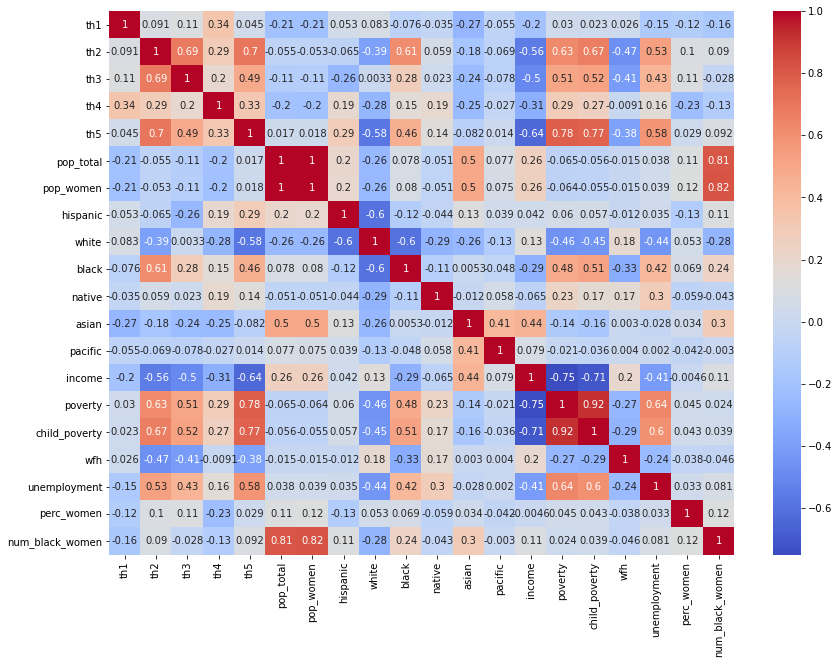

In [174]:
plt.figure(figsize = (14, 10))
sns.heatmap(train.corr(), annot=True, cmap="coolwarm")

## Q. When looking at ethnicities across counties, which groups have the highest `th3` scores?
I will create bins for `white`, `black`, `hispanic`, and `native` by quartile and compare the `th3` scores for each quartile by group

In [200]:
# white
for df in train, validate, test:
    df['quart_white'] = pd.qcut(df.white, 4, \
            labels = ['q1: < 66%_white', 'q2: < 84%_white', 'q3: < 92%_white', 'q4: < 92%_white'])

In [186]:
# black
for df in train, validate, test:
    df['quart_black'] = pd.qcut(df.black, 4, \
            labels = ['q1: = 00%_black', 'q2: < 03%_black', 'q3: < 10%_black', 'q4: > 10%_black'])

In [201]:
# hispanic
for df in train, validate, test:
    df['quart_hisp'] = pd.qcut(train.hispanic, 4, \
            labels = ['q1: < 02%_hisp', 'q2: < 04%_hisp', 'q3: < 09%_hisp', 'q4: < 09%_hisp'])

In [202]:
# native
for df in train, validate, test:
    df['quart_native'] = pd.qcut(train.native, 4, \
            labels = ['q1: = 00%_native', 'q2: < .3%_native', 'q3: < .6%_native', 'q4: > .6%_native'])

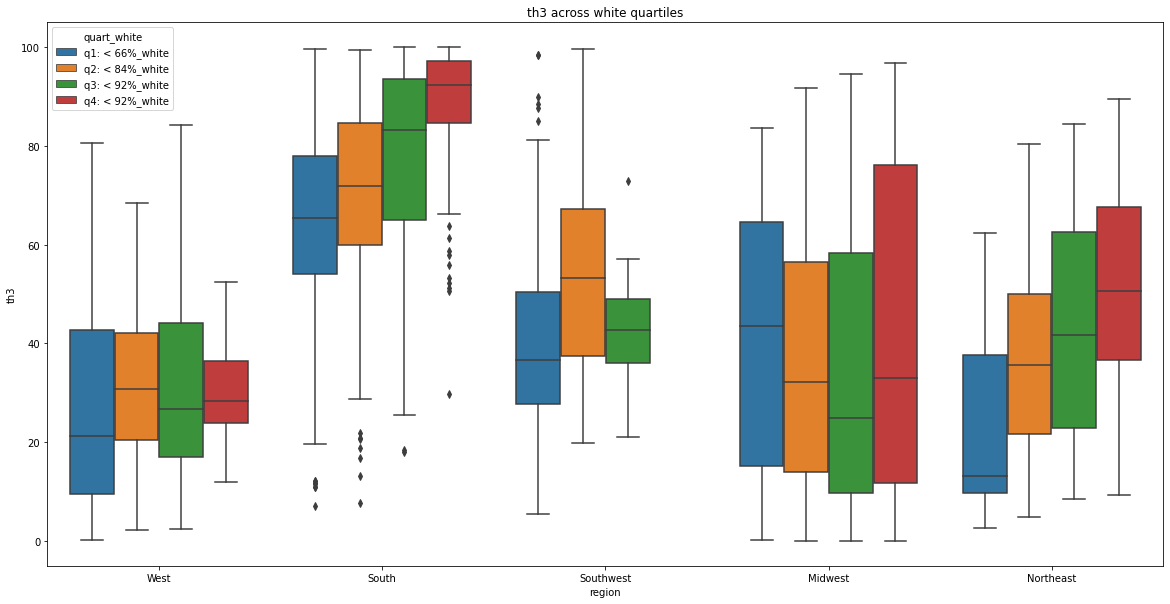

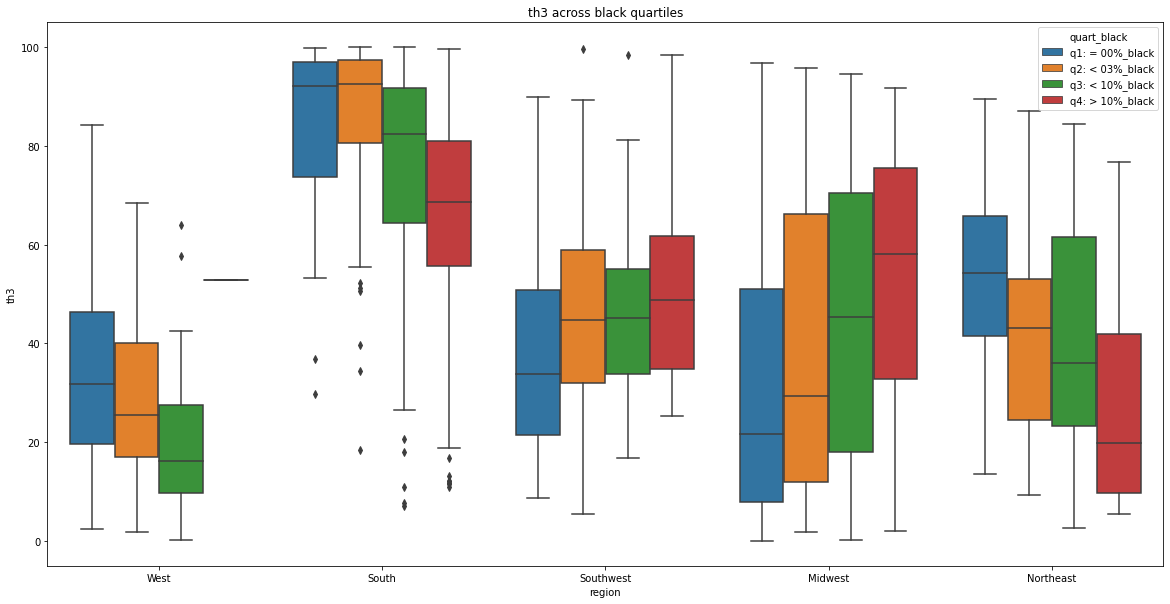

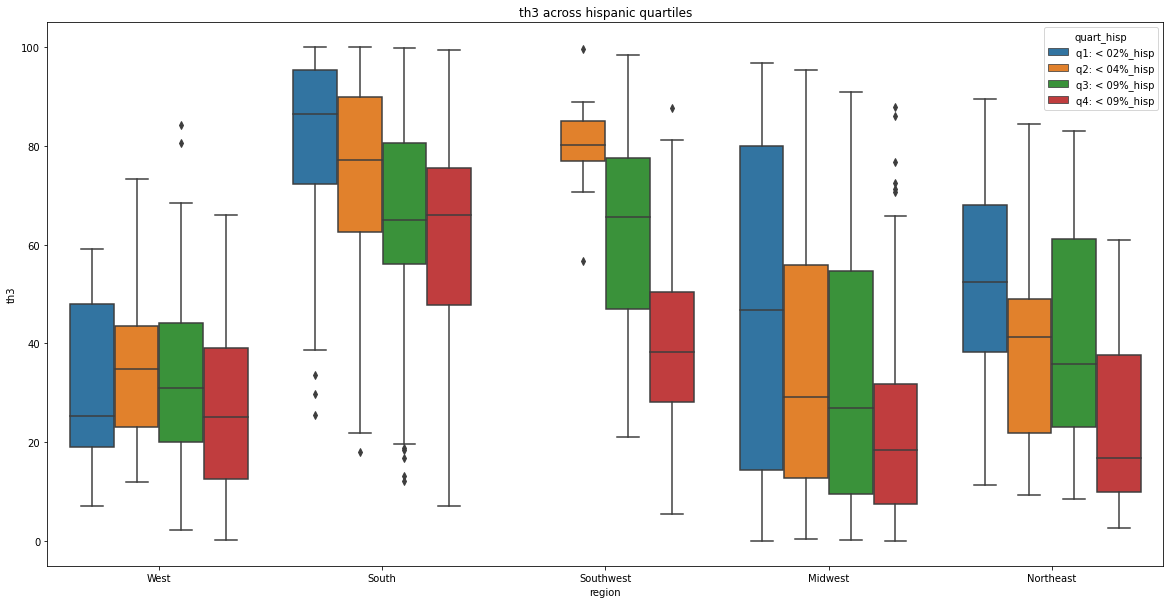

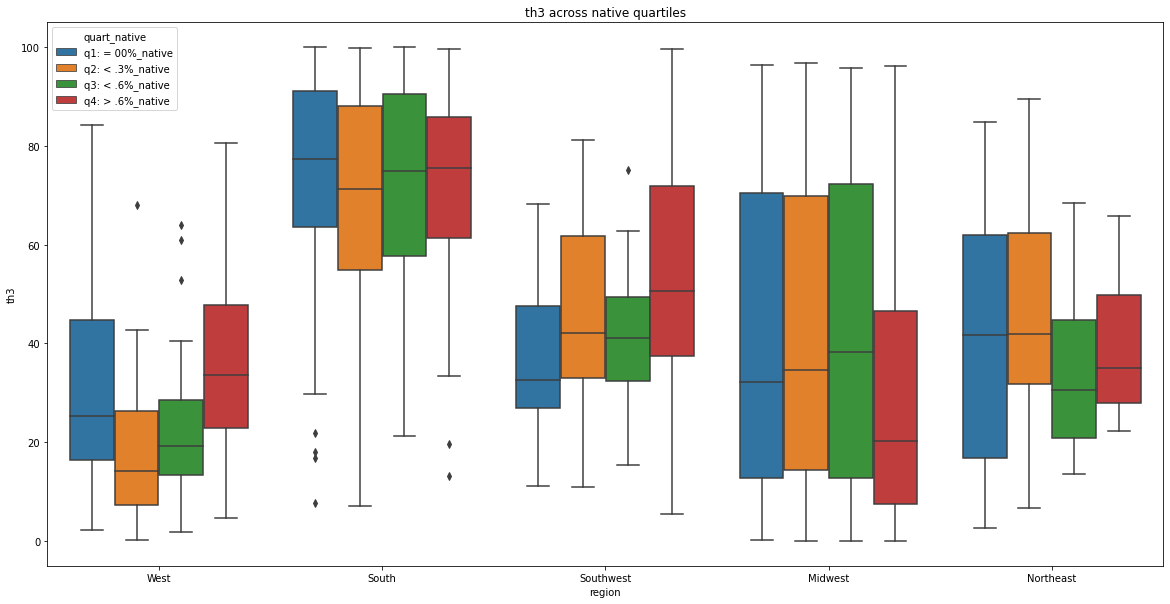

In [225]:
plt.figure(figsize = (20, 10))
sns.boxplot(data = train, y = 'th3', x = 'region', hue = 'quart_white')
plt.title('th3 across white quartiles')
plt.show();
print()

plt.figure(figsize = (20, 10))
sns.boxplot(data = train, y = 'th3', x = 'region', hue = 'quart_black')
plt.title('th3 across black quartiles')
plt.show();
print()

plt.figure(figsize = (20, 10))
sns.boxplot(data = train, y = 'th3', x = 'region', hue = 'quart_hisp')
plt.title('th3 across hispanic quartiles')
plt.show();
print()

plt.figure(figsize = (20, 10))
sns.boxplot(data = train, y = 'th3', x = 'region', hue = 'quart_native')
plt.title('th3 across native quartiles')
plt.show();
print()

### Different things are happening in each region in terms of trends and when `th3` is increasing or decreasing as a particular ethnicities percentage of the population increases or decreases.

## Q. Which region has the the highest `th3` score?

In [248]:
pd.DataFrame(train.groupby('region').mean().th3).sort_values(by = 'th3', ascending = False)

,th3
region,
South,72.369
Southwest,45.440
Northeast,41.481
Midwest,38.541
West,30.528


#### It appears that the `South` is the region with the highest `th3` score. 
> I will run a 1 sample, 1 tailed ttest to see if the mean `th3` score in the South region is higher than the mean `th3` score across all regions.
> - 1 sample: bc I am comparing a sample mean (West) against the population mean (all regions)
> - 1 tail: I want to know if it is greater than the population mean
- $H$o The mean `th3` scores are higher in the `South` than in the mean score of all regions.
- $H$a The mean `th3` scores are not higher in the `South` than in the mean score of all regions. 
- α = .05

In [294]:
# setting alpha
α = .05

# th3 scores of southern region, subpopulation
south_series = train[train.region == 'South'].th3

# population mean th3 score across all regions
th3_mean = train.th3.mean()

t, p = stats.ttest_1samp(south_series, th3_mean)
p = p/2 #one tailed

print(f't = {t:.3f}')
print(f'p = {p:.3f}')
if p < α:
    print(f'The results of our hypothesis test are statistically signficant.\nThere is a {round((p*100), 2)}% likelihood that we observed this randomly by chance.')
else:
    print(f'The results of our hypothesis test are not statistically signficant.\nThere is a {round((p*100), 2)}% likelihood that we observed this randomly by chance.')

t = 26.627
p = 0.000
The results of our hypothesis test are statistically signficant.
There is a 0.0% likelihood that we observed this randomly by chance.


## Q. Do counties with higher incomes have lower `th3` scores?

In [277]:
# creating a column of binned th3 scores
train['th3_quart'] = pd.cut(train.th3, 4, labels = ['q1', 'q2', 'q3', 'q4'])

<AxesSubplot:xlabel='income', ylabel='th3_quart'>

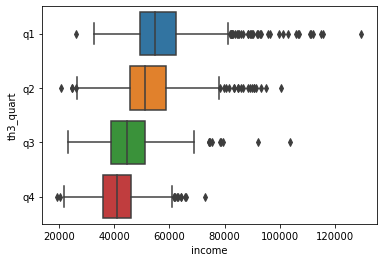

In [276]:
sns.boxplot(data = train, x = 'income', y = 'th3_quart')

### I will run a one tailed, one sample independent ttest and confirm that there is a statistically significant greater averager `th3` score for counties with higher average incomes.
- $H$o: The mean average income of counties with the lowest `th3` scores is the same as the overall average county income. 
- $H$a: The mean average income of counties with the lowest `th3` scores is not the same as the overall average county income. 
- alpha: .05

In [292]:
def one_samp_ttest(sample_series, mean):
    '''
THIS FUNCTION TAKES IN A SAMPLE SERIES FROM A DF AND THE POPULATION OF THAT SERIES' MEAN AND
RUNS A 1 SAMPLE TTEST. IT PRINTS THE T AND P VALUES AND RUNS AN IF STATEMENT THAT USES THOSE
VALUES TO DETERMINE THE STATISTICAL SIGNIFICANCE OF THE RESULTS AND THE LIKELYHOOD THAT THEY
WERE OBSERVED DUE TO RANDOM SAMPLING.
    '''
    
    t, p = stats.ttest_1samp(sample_series, mean)
    p = p/2

    print(f't = {t:.3f}')
    print(f'p = {p:.3f}')
    
    if p < α:
        print(f'We reject H(o) and conclude the results of our hypothesis test are statistically signficant.\nThere is a {round((p*100), 2)}% likelihood that we observed this randomly by chance.')
    else:
        print(f'We fail to reject H(o) and conlcude the results of our hypothesis test are not statistically signficant.\nThere is a {round((p*100), 2)}% likelihood that we observed this randomly by chance.')

In [293]:
one_samp_ttest(train[train.th3_quart == 'q1'].income, train.income.mean())

t = 12.584
p = 0.000
We reject H(o) and conclude the results of our hypothesis test are statistically signficant.
There is a 0.0% likelihood that we observed this randomly by chance.


## Q. Do counties with higher percentages of their workforce working from home have lower `th3` scores?

<AxesSubplot:xlabel='wfh', ylabel='th3_quart'>

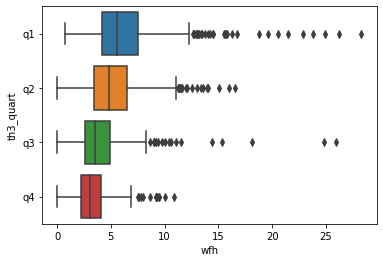

In [295]:
sns.boxplot(data = train, x = 'wfh', y = 'th3_quart')

### There are a lot of outliers but looking at the medians, there appears to be a slight difference, with the lowest `q1` of `th3` scores having higher `wfh` rates. 
I will run a 1 sample, 1 tail ttest to see if the observed difference is a statistically significant.
- $H$o: Counties with `th3` scores in the lowest quarter have avergae higher `wfh` rates than the average `wfh` across all counties. 
- $H$a: Counties with `th3` scores in the lowest quarter do not have avergae higher `wfh` rates than the average `wfh` across all counties. 
- alpha: .05

In [296]:
one_samp_ttest(train[train.th3_quart == 'q1'].wfh, train.wfh.mean())

t = 9.950
p = 0.000
We reject H(o) and conclude the results of our hypothesis test are statistically signficant.
There is a 0.0% likelihood that we observed this randomly by chance.


## Q. Do counties with higher `percentages of women` have lower `th3` scores?

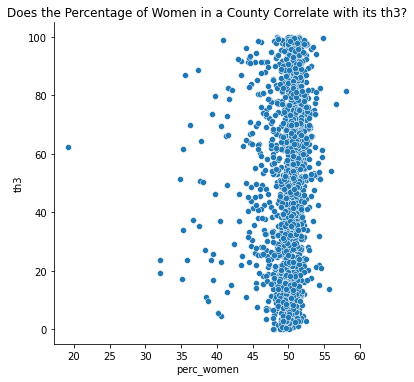

In [309]:
sns.relplot(data = train, x = 'perc_women', y = 'th3')#, hue = 'th3_quart')
plt.title('Does the Percentage of Women in a County Correlate with its th3?')
plt.show()

#### It appears that the `th3` scores are pretty evenly distributed at the different values for percentages of women.
I will run a `SpearmansR` correlation test to confirm.
- $H$o: A county's `percentage of women` is not correlated with its `th3` score. 
- $H$a: A county's `percentage of women` is not correlated with its `th3` score.
- alpha: .05


In [301]:
r, p = stats.spearmanr(df['perc_women'], df['th3'])
print(f'The r-value or correlation coefficient is: {round(r, 2)}')
print(f'The p-value is: {p}\nThere is {round(p, 1)}% chance that we see these results by chance.')

The r-value or correlation coefficient is: 0.22
The p-value is: 1.9585658978302323e-08
There is 0.0% chance that we see these results by chance.


#### The correlation is pretty low `perc_women` is not a feature that would be useful for modeling and predicting `th3`

## Q. Does the physical health vulnerability index score, measured by a county's `th2` index score, correlate with its `th3` score?

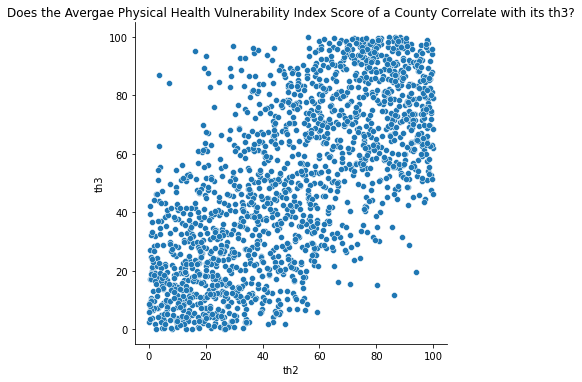

In [310]:
sns.relplot(data = train, x = 'th2', y = 'th3')#, hue = 'th3_quart')
plt.title('Does the Avergae Physical Health Vulnerability Index Score of a County Correlate with its th3?')
plt.show()

### There appears to be a lose upward correlation. I will run another `spearmansr` correlation test to quantify the correlation and determine whether the results are statistically significant.
- $H$o: There is no statistically significant correlation between a county's avergae physical health vulnerability score (`th2`) and its mental health and substance abuse vulnerability score (`th3`).
- $H$a: There is a statistically significant correlation between a county's avergae physical health vulnerability score (`th2`) and its mental health and substance abuse vulnerability score (`th3`).
- alpha = .05


In [311]:
r, p = stats.spearmanr(df['th2'], df['th3'])
print(f'The r-value or correlation coefficient is: {round(r, 2)}')
print(f'The p-value is: {p}\nThere is {round(p, 1)}% chance that we see these results by chance.')

The r-value or correlation coefficient is: 0.68
The p-value is: 4.320397404189088e-85
There is 0.0% chance that we see these results by chance.


## There is a pretty high correlation here and this is statistically significant and a feature that I definitely would like to use for modeling.

# Explore Takeaways
### `region`
- The South `region` has a higher mean `th3` score than the mean `th3` score of all the regions.
- When breaking the data up geographically by `region` and then demographically by ethincity, `region` had a greater impact on a countys `th3` score.

###`income`
- Counties with the lowest quartile `th3` had higher avergae incomes that then average incomes of all counties combined.

### 'wfh'
- Counties with the lowest quartile `th3` had higher average rates of their workforce working from home than the avergae `wfh` rate across all counties.

### `th2` Physical Health Vulnerability Index Score
- Physical Health Vulnerability Index, measured by a companys `th2` score, was highly correlated with `th3`

# Features to Use in Modeling
- `region`
- `income`
- `wfh`
>I will need to `get_dummies` for the regions and then drop the `region` column<br>
>I will then scale the other continuous variables


In [316]:
def cols_for_modeling(train, validate, test):
    
    model_cols = ['th2', 'region', 'income', 'wfh', 'th3']

    train = train[model_cols]
    validate = validate[model_cols]
    test = test[model_cols]
    
    return train, validate, test
    

In [317]:
train, validate, test = cols_for_modeling(train, validate, test)

In [328]:
train = pd.concat([train, pd.get_dummies(train.region)], axis = 1).drop(columns = ['region'])
validate = pd.concat([validate, pd.get_dummies(validate.region)], axis = 1).drop(columns = ['region'])
test = pd.concat([test, pd.get_dummies(test.region)], axis = 1).drop(columns = ['region'])

## Now I will split the data into `X_train` and `y`

In [331]:
X_train = train.drop(columns = ['th3'])
y_train = train.th3

X_validate = validate.drop(columns = ['th3'])
y_validate = validate.th3

X_test = test.drop(columns = ['th3'])
y_test = test.th3

### I am going to use the `RobustScaler` because I would like to preserve outliers.

In [333]:
train.head(2)

,th2,income,wfh,th3,Midwest,Northeast,South,Southwest,West
41013,33.650,41777,6.500,64.150,0,0,0,0,1
45005,98.310,23331,1.600,78.920,0,0,1,0,0


In [334]:
cols_to_scale = ['th2', 'income', 'wfh']

In [339]:
# creating scaler object
scaler = sklearn.preprocessing.RobustScaler()

# fitting the scaler on X_train
scaler.fit(X_train[cols_to_scale])

# scaling each X dataframe of features
X_train_scaled = pd.DataFrame(scaler.transform(X_train[cols_to_scale]))
X_train_scaled.columns = X_train[cols_to_scale].columns
X_train_scaled.merge(X_train)

# X_validate_scaled = pd.DataFrame(scaler.transform(X_validate))
# X_validate_scaled.columns = X_validate.columns

# X_test_scaled = pd.DataFrame(scaler.transform(X_test))
# X_test_scaled.columns = X_test.columns

X_train_scaled.head()

,th2,income,wfh
0,-0.321,-0.413,0.828
1,0.965,-1.694,-0.862
2,0.292,0.110,-0.172
3,-0.633,1.338,-0.276
4,0.848,-0.713,0.034
